In [1]:
cd ..

/Users/minghuang/Documents/git/SEA_traffic_accident_prediction


In [2]:
from data_processing_scripts import socrata_api_wrapper as saw
from data_processing_scripts import psql_helper as ph 
from data_processing_scripts import footballdb_scraper as fs
from data_processing_scripts import baseball_almanac_scraper as bas
from data_processing_scripts import wunderground_scraper as ws
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
import psycopg2
import seaborn as sns
%matplotlib inline

In [2]:
wunder = ws.WundergroundScraper()
wunder.download_date_range('2009-06-17', '2015-09-14')

data/weather.csv downloaded.


In [8]:
token = 'Opp5gz1KaGplrPjbqnSsWkqHB'

In [9]:
api = saw.SocrataAPI(token)
psql = ph.PsqlConnection(db='traffic_accident', user='minghuang')

Connection Open


### Get 911 response data (original data source intended, traffic accident data seemed insufficient)

In [4]:
r = api.request('https://data.seattle.gov/resource/pu5n-trf4.json')
headers = r.get_headers()
r.set_primary_id('cad_cdw_id')

In [5]:
r.download_csv(file_name='data/raw_911_response.csv')

Download Complete


In [6]:
#psql.drop_table('raw_911_response')
#psql.create_table(headers, 'raw_911_response')
#psql.insert_csv('raw_911_response', '/Users/minghuang/Documents/temp/911calls.csv')

Table raw_911_response dropped.
Table raw_911_response created in traffic_accident
CSV inserted into raw_911_response.


###Get road weather data

In [9]:
r = api.request('https://data.seattle.gov/resource/egc4-d24i.json')
headers = r.get_headers()
r.set_primary_id('recordid')

Connection Open


In [12]:
r.download_csv(file_name='data/raw_road_weather.csv')

Download Complete


In [8]:
#psql.drop_table('raw_road_weather')
#psql.create_table(headers, 'raw_road_weather')
#psql.insert_csv('raw_road_weather', '/Users/minghuang/Documents/temp/roadweather.csv')

Table raw_road_weather dropped.
Table raw_road_weather created in traffic_accident
CSV inserted into raw_road_weather.


###Get Mariner and Seahawks schedule

In [13]:
mariner = bas.BaseballAlmanacScraper()
mariner.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [14]:
seahawks = fs.FootballdbScraper()
seahawks.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [12]:
psql.load_csvs_in_directory('/Users/minghuang/Documents/git/SEA_traffic_accident_prediction/data')

Table raw_traffic_accident dropped.
Table raw_traffic_accident created in traffic_accident
CSV inserted into raw_traffic_accident.


In [13]:
psql.end_connection()

Connection Closed


#EDA

In [181]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
query = "select * from raw_911_response where event_clearance_code like '4%';"
df = pd.read_sql_query(query, con=conn)
conn.close()

In [182]:
df.head()

,cad_cdw_id,at_scene_time,cad_event_number,census_tract,district_sector,event_clearance_code,event_clearance_date,event_clearance_description,event_clearance_group,event_clearance_subgroup,general_offense_number,hundred_block_location,incident_location,initial_type_description,initial_type_group,initial_type_subgroup,latitude,longitude,zone_beat
0,58014,,10000307639,9300.3087,O,460,2010-09-02T21:14:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2010307639,45XX BLOCK OF DIAGONAL AVE S,"{u'type': u'Point', u'coordinates': [-122.3387...",,,,47.562643686,-122.338763147,O2
1,580138,2012-07-13T02:25:00.000,12000224040,8100.2028,K,460,2012-07-13T02:29:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224040,5XX BLOCK OF 4TH AVE,"{u'type': u'Point', u'coordinates': [-122.3299...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.602876296,-122.329971419,K1
2,580128,,15000034202,8002.2006,M,440,2015-01-30T14:52:00.000,MOTORIST ASSIST,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,201534202,1 AV / LENORA ST,"{u'type': u'Point', u'coordinates': [-122.3439...",TRAFFIC - BLOCKING ROADWAY,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.611836283,-122.34391552,M1
3,580126,2012-07-13T13:01:00.000,12000224547,8100.1000,M,460,2012-07-13T13:08:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224547,13XX BLOCK OF 1ST AVE,"{u'type': u'Point', u'coordinates': [-122.3386...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.607331584,-122.33865117,M1
4,580123,2012-07-13T15:44:00.000,12000224768,9300.3018,O,460,2012-07-13T15:59:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224768,19XX BLOCK OF 1ST AVE S,"{u'type': u'Point', u'coordinates': [-122.3341...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.585041313,-122.334198304,O1


In [183]:
len(df.zone_beat.unique())

81

In [184]:
#df.initial_type_description.unique()

In [185]:
lgt = df.longitude.astype(float).values
lat = df.latitude.astype(float).values

In [186]:
print min(lgt), max(lgt)
print min(lat), max(lat)

-122.432252473 -122.217417743
47.448669479 47.777823617


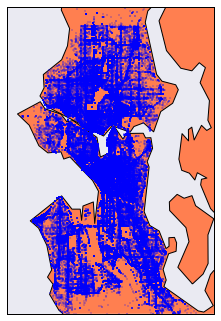

In [187]:
m = Basemap(projection='merc',# lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.45, llcrnrlat=47.5,
    urcrnrlon=-122.2, urcrnrlat=47.75)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

x, y = m(lgt, lat)
m.plot(x, y, 'bo', markersize=1)
 
plt.show()

#### Lets look at my sql transformed data (additional EDA were done in SQL, but not recorded)

In [3]:
query = 'select * from compiled_data2;'

In [4]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
df2 = pd.read_sql_query(query, con=conn)
conn.close()

In [5]:
df2 = df2.reindex(np.random.permutation(df2.index))

In [6]:
df2 = df2.sample(100000)
#df2 = df2[df2.zone_beat_id == 41]

In [7]:
df2.head()

,zone_beat_id,condition_id,winddir_id,intersections,hour,dow,month,mariner_plays,seahawk_plays,dewpoint,have_gustspeed,have_heatindex,humidity,have_precip,pressure,temp,visibility,windspeed,label
252770,15,3,1,224,2,6,7,1,0,48.9,0,0,64,0,30.15,61.0,10,0.0,0
1009398,7,1,11,352,19,3,4,1,0,39.2,0,0,51,0,30.11,57.2,10,4.6,0
512051,12,4,8,245,7,1,2,0,0,37.4,0,0,93,1,30.05,39.2,2,4.6,0
895271,18,2,14,324,11,1,1,0,0,51.1,0,0,81,0,30.24,57.0,4,9.2,0
495428,15,4,14,224,16,1,2,0,0,44.6,1,0,82,1,30.01,50.0,6,13.8,0


In [8]:
df3 = df2[['dewpoint', 'have_gustspeed', 'have_heatindex', 'humidity', 'have_precip', 'pressure', 'temp', 'visibility', 'windspeed', 'label']]

/Users/minghuang/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


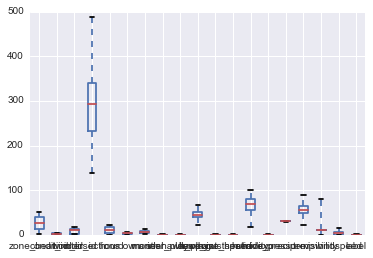

In [9]:
plot = df2.boxplot()

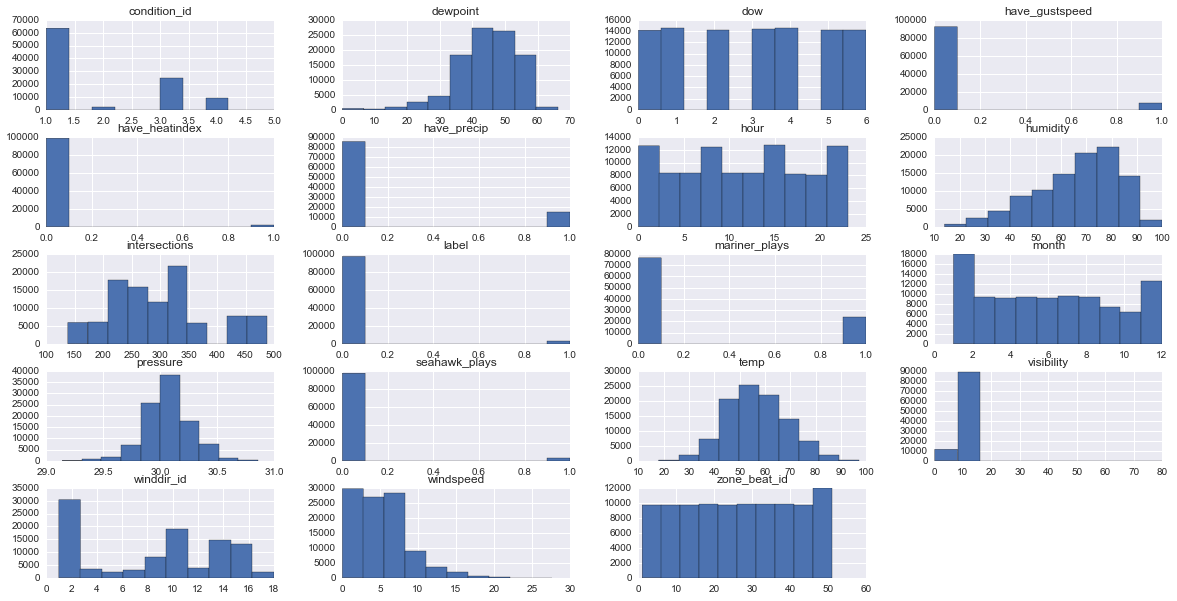

In [10]:
plot = df2.hist(figsize=(20, 10))

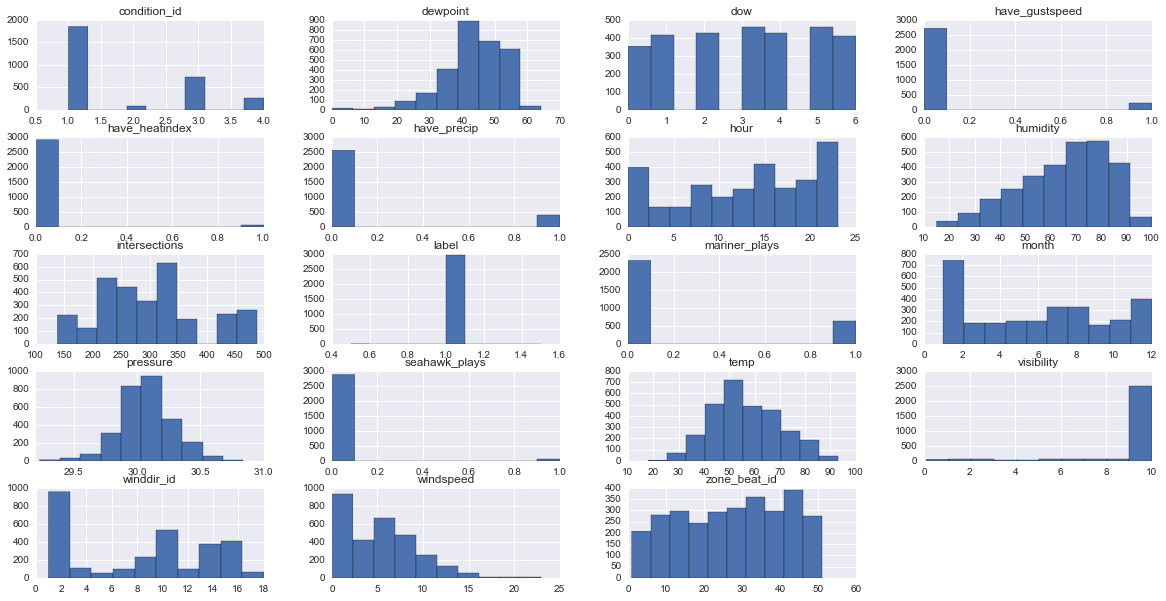

In [11]:
plot = df2[df2.label == 1].hist(figsize=(20, 10))

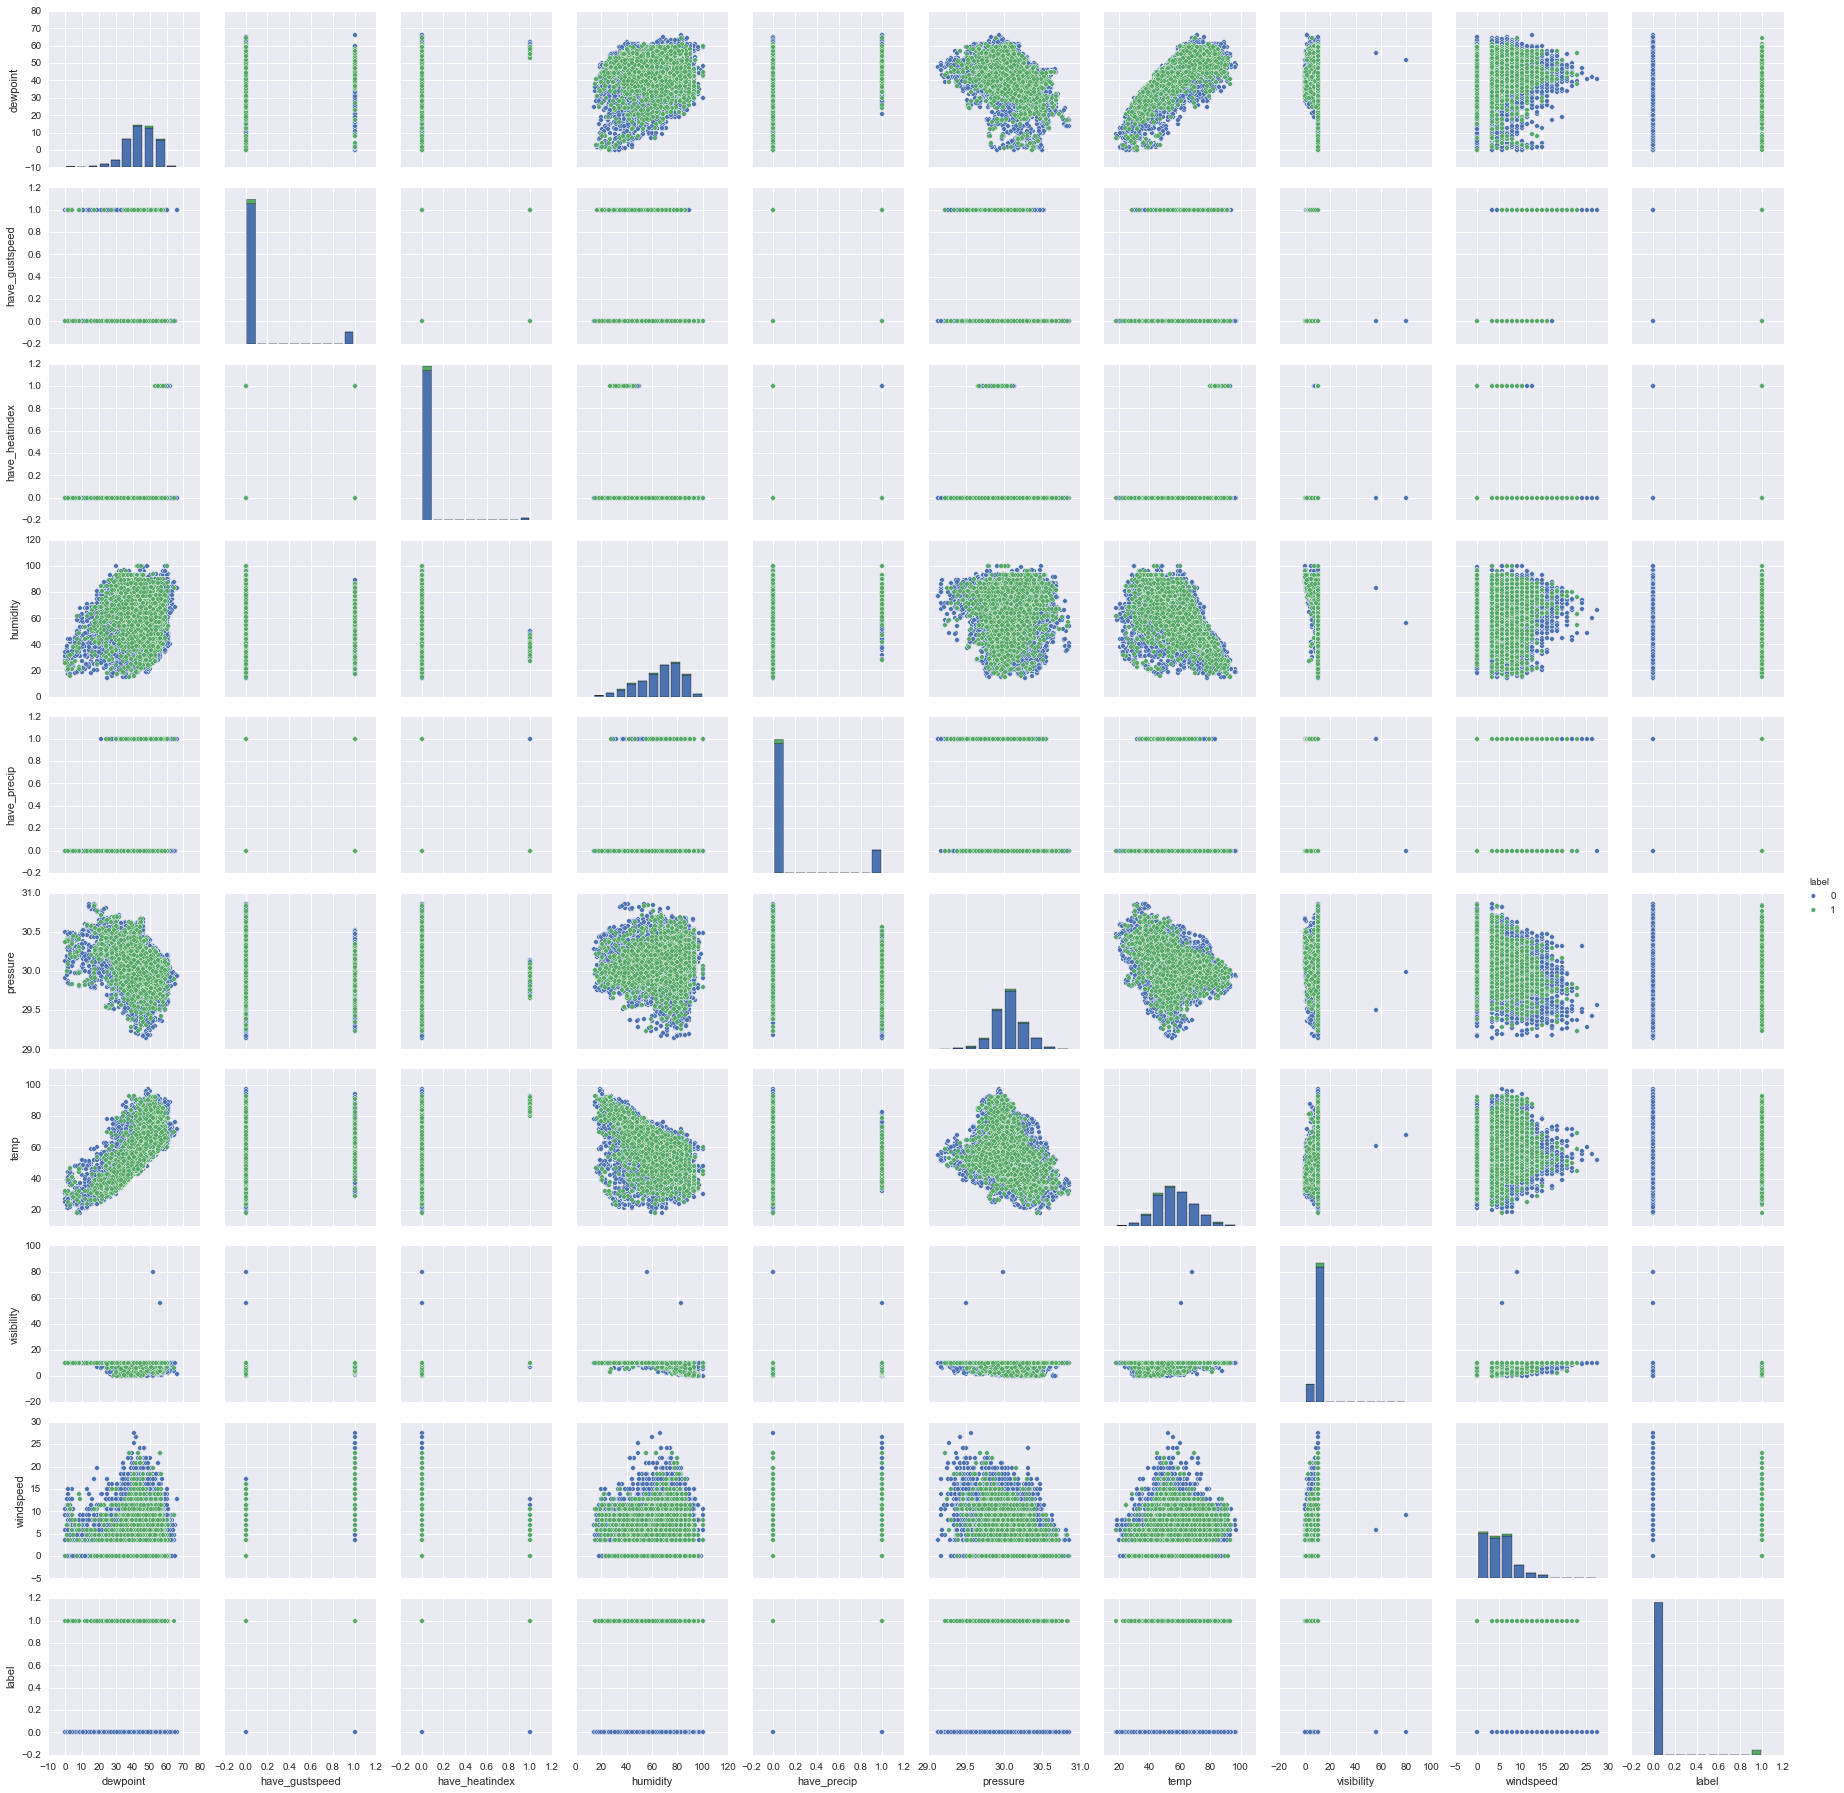

In [12]:
sns.set()
sns.pairplot(df3, hue='label')

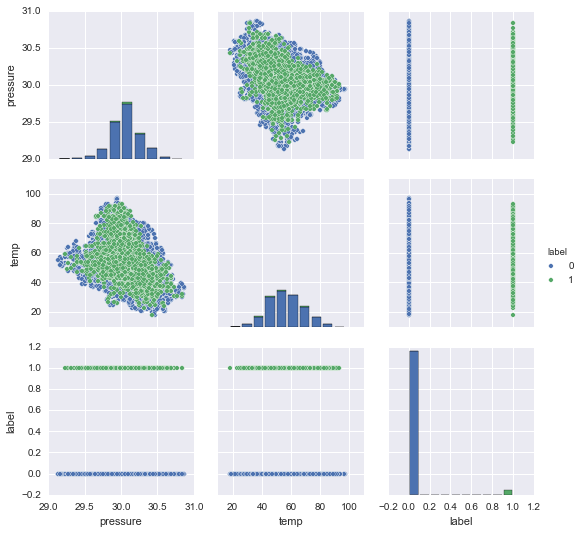

In [13]:
sns.set()
sns.pairplot(df3[['pressure', 'temp', 'label']], hue='label')

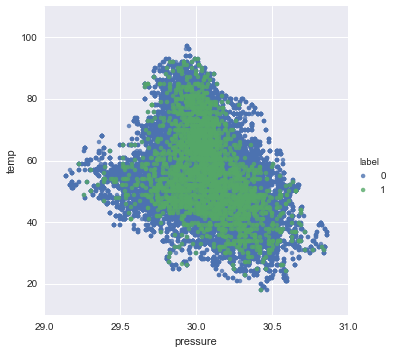

In [14]:
sns.set()
sns.lmplot('pressure', 'temp', hue='label', data=df3, fit_reg=False)

In [15]:
df2_pos = df2[df2.label == 1]
df2_neg = df2[df2.label == 0]

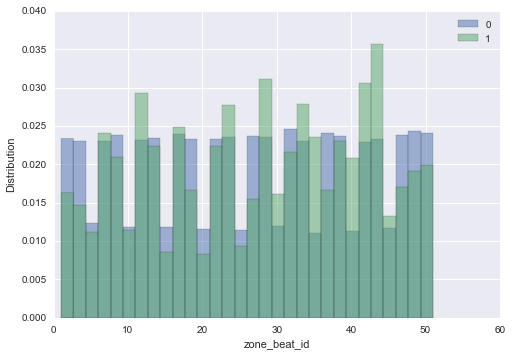

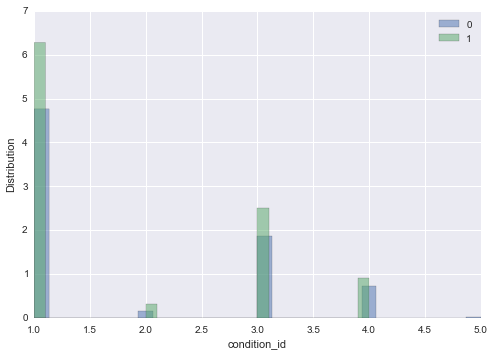

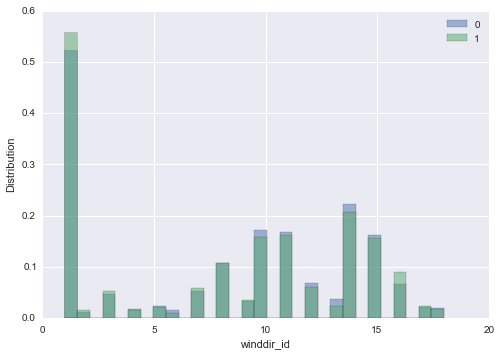

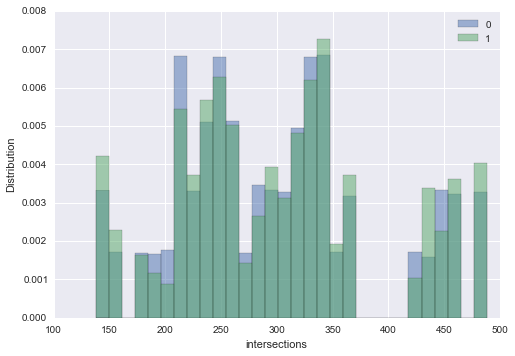

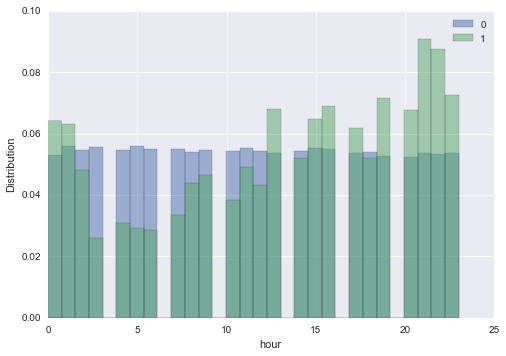

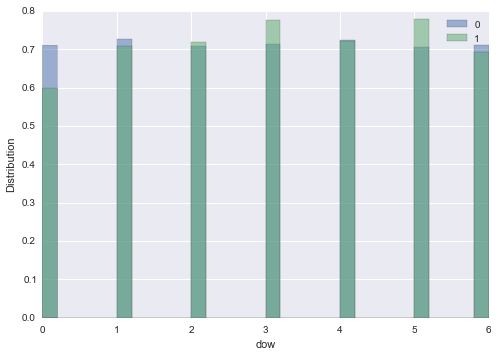

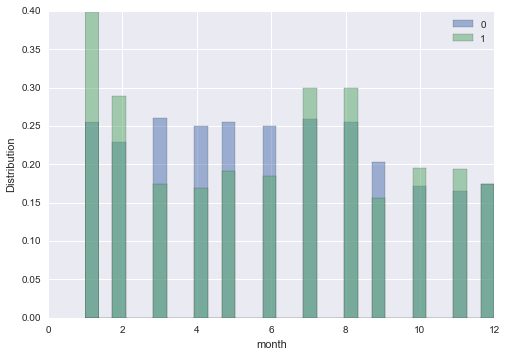

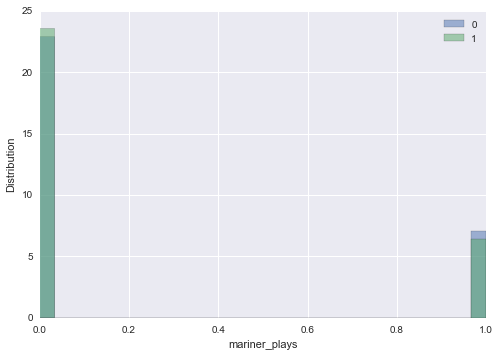

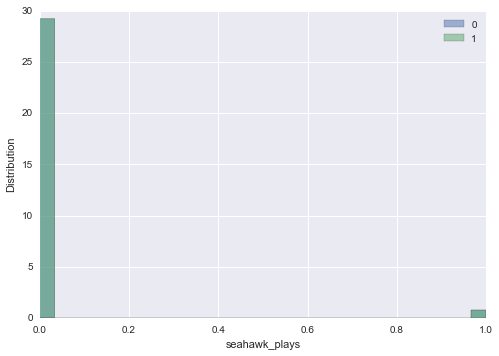

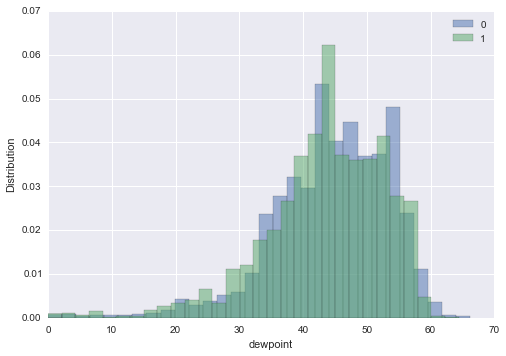

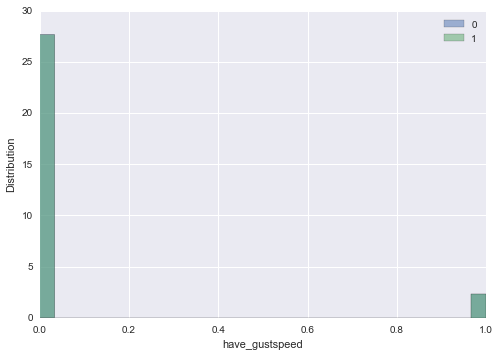

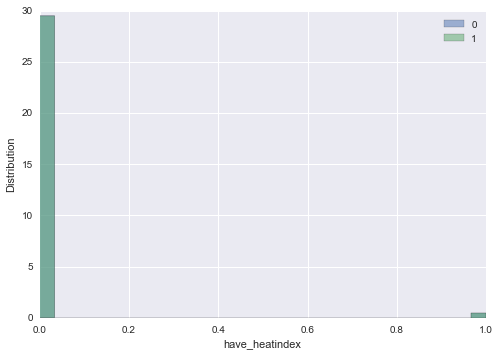

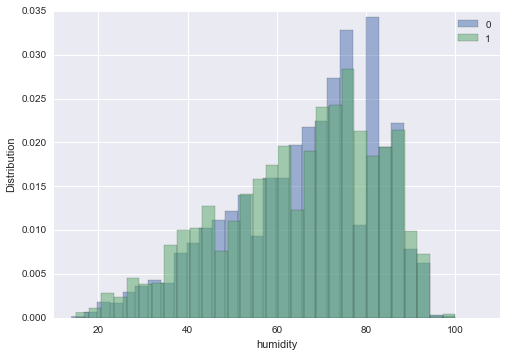

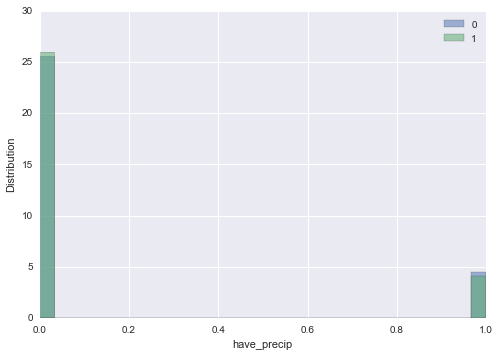

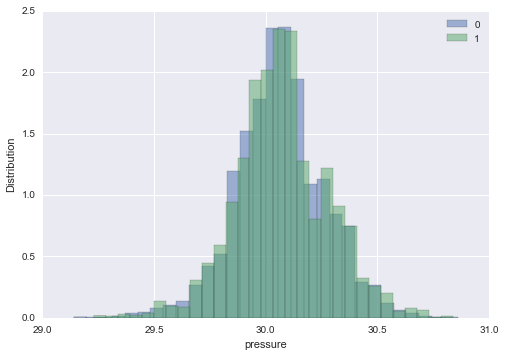

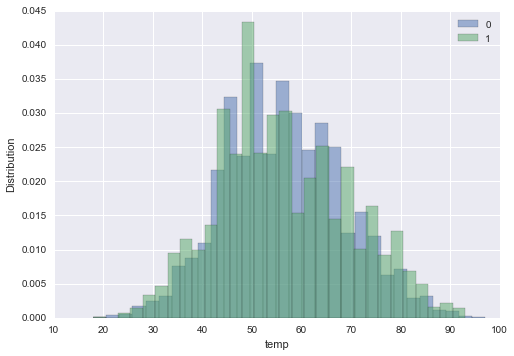

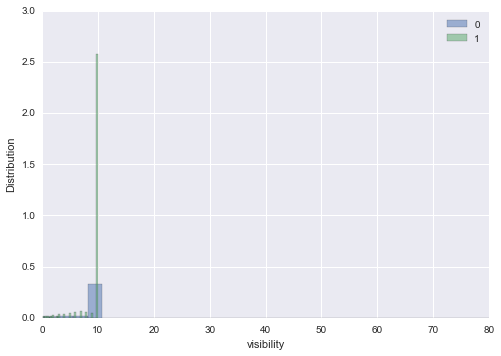

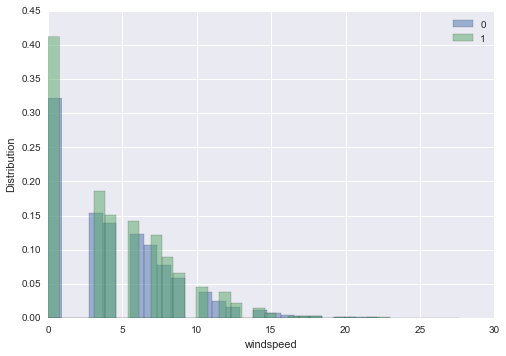

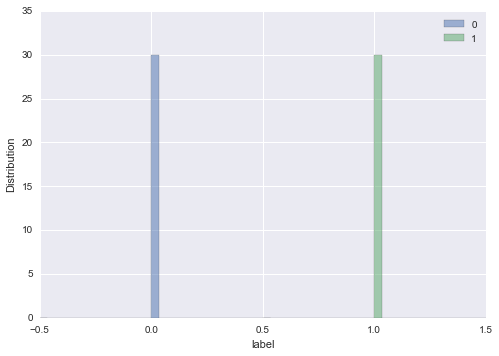

In [16]:
for col in df2.columns:
    plt.hist(df2_neg[col].values, bins=30, alpha=0.5, label='0', normed=True)
    plt.hist(df2_pos[col].values, bins=30, alpha=0.5, label='1', normed=True)
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('Distribution')
    plt.show()

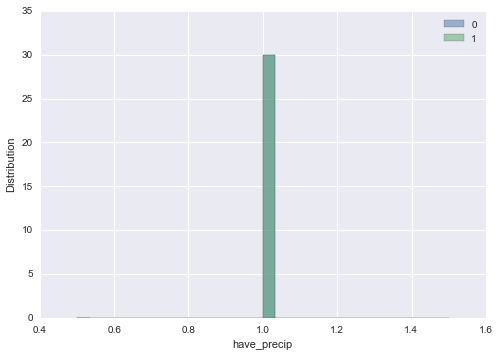

In [17]:
col = 'have_precip'
plt.hist(df2_neg[col][df2_neg[col] > 0].values, bins=30, alpha=0.5, label='0', normed=True)
plt.hist(df2_pos[col][df2_pos[col] > 0].values, bins=30, alpha=0.5, label='1', normed=True)
plt.legend()
plt.xlabel(col)
plt.ylabel('Distribution')
plt.show()

In [18]:
print '0 label count:', df2[df2.label == 0]['label'].count()
print '1 label count:', df2[df2.label == 1]['label'].count()

0 label count: 97053
1 label count: 2947


In [19]:
print 1. * df2[df2.label == 1][df2.condition_id == 5]['condition_id'].count() / df2[df2.label == 1]['label'].count()
print 1. * df2[df2.label == 0][df2.condition_id == 5]['condition_id'].count() / df2[df2.label == 0]['label'].count()

0.0
0.000886113772887


/Users/minghuang/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [20]:
y = df2.pop('label').values
#df2.sort(axis=1).head().T

In [21]:
X = df2.sort(axis=1).values

In [22]:
df2.sort(axis=1).head().T

,252770,1009398,512051,895271,495428
condition_id,3.00,1.00,4.00,2.00,4.00
dewpoint,48.90,39.20,37.40,51.10,44.60
dow,6.00,3.00,1.00,1.00,1.00
have_gustspeed,0.00,0.00,0.00,0.00,1.00
have_heatindex,0.00,0.00,0.00,0.00,0.00
have_precip,0.00,0.00,1.00,0.00,1.00
hour,2.00,19.00,7.00,11.00,16.00
humidity,64.00,51.00,93.00,81.00,82.00
intersections,224.00,352.00,245.00,324.00,224.00
mariner_plays,1.00,1.00,0.00,0.00,0.00


In [23]:
len(df2.condition_id.unique())

5

#### Doesn't look great... lets just try some models

In [28]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat = encoder.fit_transform(X)
scaler = StandardScaler()
mat2 = scaler.fit_transform(mat.toarray())

In [29]:
logit = LogisticRegression(class_weight='auto')

In [30]:
cvs = cross_val_score(logit, mat2, y, scoring='roc_auc', cv=5)

In [31]:
cvs

array([ 0.64563104,  0.66195369,  0.64527193,  0.64634765,  0.62081069])

In [32]:
np.mean(cvs)

0.64400299917705484

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [34]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat_train = encoder.fit_transform(X_train)
scaler = StandardScaler()
mat_train2 = scaler.fit_transform(mat_train.toarray())
logit = LogisticRegression(class_weight='auto').fit(mat_train2, y_train)
mat_test = encoder.transform(X_test)
mat_test2 = scaler.transform(mat_test.toarray())

In [35]:
predict = logit.predict(mat_test2)
roc_auc_score(predict, y_test)

0.51230861291389573

In [144]:
ada = AdaBoostClassifier()
cvs = cross_val_score(ada, mat2, y, scoring='roc_auc', cv=5)

In [145]:
cvs

array([ 0.63532257,  0.65860786,  0.64022366,  0.63365213,  0.63636093])

In [149]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat_train = encoder.fit_transform(X_train)
scaler = StandardScaler()
mat_train2 = scaler.fit_transform(mat_train.toarray())
ada = AdaBoostClassifier().fit(mat_train2, y_train)
mat_test = encoder.transform(X_test)
mat_test2 = scaler.transform(mat_test.toarray())

In [150]:
predict = ada.predict(mat_test2)
roc_auc_score(predict, y_test)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [81]:
bayes = GaussianNB()
cvs = cross_val_score(bayes, mat.toarray(), y, scoring='roc_auc', cv=5)

In [82]:
cvs

array([ 0.57715189,  0.51554091,  0.53790482,  0.54575983,  0.53985857])

In [83]:
np.mean(cvs)

0.54324320325162045

In [84]:
bayes.fit(mat_train.toarray(), y_train)
roc_auc_score(bayes.predict(mat_test.toarray()), y_test)

0.51105852689404996

In [21]:
rnf = RandomForestClassifier(class_weight='auto', n_estimators=200)

In [22]:
cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.62354232  0.62031242  0.60442796  0.62486563  0.61153344  0.59396
  0.61241906  0.61732736  0.62677079  0.61517247]
0.615033142918


In [23]:
rnf.fit(X_train, y_train)
roc_auc_score(rnf.predict(X_test), y_test)

0.54689375750300118

In [24]:
gbc = GradientBoostingClassifier()

In [25]:
cvs = cross_val_score(gbc, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.64778094  0.65726396  0.65503642  0.63796406  0.66797456  0.62909502
  0.65952696  0.67136892  0.66499142  0.65643397]
0.654743622417


In [26]:
gbc.fit(X_train, y_train)
roc_auc_score(gbc.predict(X_test), y_test)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [91]:
max([x[1] for x in gbc.predict_proba(X_test)])

0.6377142759148442

In [55]:
svc = SVC(class_weight='auto')

In [ ]:
cvs = cross_val_score(svc, mat, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

#### Lets try expanding on RNF

In [68]:
pd.Series([x[1] for x in rnf.predict_proba(X_test)]).unique()

array([ 0.02,  0.08,  0.03,  0.01,  0.04,  0.05,  0.  ,  0.21,  0.06,
        0.09,  0.11,  0.1 ,  0.16,  0.56,  0.24,  0.07,  0.2 ,  0.12,
        0.39,  0.14,  0.13,  0.15,  0.31,  0.34,  0.25,  0.17,  0.18,
        0.36,  0.35,  0.29,  0.43,  0.23,  0.19,  0.32,  0.49,  0.44,  0.52])

In [79]:
auc = []
for n in xrange(10, 101):
    rnf = RandomForestClassifier(class_weight='auto', n_estimators=n)
    cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=5)
    auc.append(np.mean(cvs))

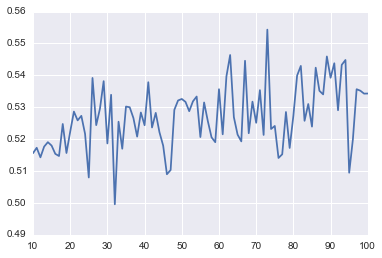

In [80]:
plt.plot(range(10, 101), auc)

In [ ]:
# Grid param modified to only store the ones preferred
random_forest_grid = {
                      'max_depth': [3, 6, 9],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [5, 10, 15],
                      'min_samples_leaf': [5, 10, 15],
                      'bootstrap': [False, True],
                      'n_estimators': [100],
                      'random_state': [None, 20, 200],
                      'class_weight': ['auto']
                     }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X, y)

print "best parameters:", rf_gridsearch.best_params_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


In [207]:
rnf = RandomForestClassifier(class_weight = 'auto')
rnf.fit(X_train, y_train)
rnf_df = pd.DataFrame(X_test, columns=df2.columns)
rnf_df['proba'] = pd.Series([x[1] for x in rnf.predict_proba(X_test)])
rnf_df['label'] = pd.Series(y_test)

In [208]:
rnf_df['proba_bins'] = pd.cut(rnf_df['proba'], bins=3)

In [209]:
roc_auc_score(rnf.predict(X_test), y_test)

0.72995991983967934

In [168]:
rnf_df.head().T

,0,1,2,3,4
zone_beat_id,18,17,18,18,19
condition_id,39.2,37,46.9,51.8,33.1
winddir_id,3,3,5,4,5
hour,0,0,0,21.9,0
dow,0,0,0,0,0
month,7,19,22,14,18
mariner_plays,87,71,69,68,70
seahawk_plays,0,0,0,0,0
dewpoint,12,11,11,7,11
gustspeed,0,0,0,0,0


In [169]:
rnf_df[['proba_bins', 'label']].groupby('proba_bins', as_index=False).agg({'label': ['sum','mean', 'count']})

proba_bins label                
                     sum      mean count
0  (0.025, 0.0749]    75  0.039288  1909
1  (0.0749, 0.125]     6  0.072289    83
2   (0.125, 0.175]     1  0.125000     8

####Trying multi downsampling methods

In [87]:
df2.sort(axis=1).head().T

,992250,545638,301696,646363,1047358
condition_id,4.00,3.00,1.00,1.00,1.00
dewpoint,52.00,34.00,57.20,51.80,35.10
dow,3.00,0.00,4.00,0.00,6.00
have_gustspeed,0.00,0.00,0.00,0.00,0.00
have_heatindex,0.00,0.00,0.00,0.00,0.00
have_precip,1.00,0.00,0.00,0.00,0.00
hour,18.00,18.00,3.00,0.00,20.00
humidity,75.00,50.00,82.00,82.00,28.00
intersections,425.00,458.00,248.00,458.00,214.00
mariner_plays,0.00,0.00,0.00,1.00,1.00


In [88]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat = encoder.fit_transform(X)

In [89]:
scaler = StandardScaler(with_std=False)
mat2 = scaler.fit_transform(mat.toarray())

In [90]:
logit = LogisticRegression(class_weight='auto')

In [91]:
cvs = cross_val_score(logit, mat2, y, scoring='roc_auc', cv=5)

In [92]:
cvs

array([ 0.64324094,  0.66646961,  0.64714347,  0.63896755,  0.64130224])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [94]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat = encoder.fit_transform(X_train)
scaler = StandardScaler(with_std=False)
mat2 = scaler.fit_transform(mat.toarray())

In [95]:
mat_test = encoder.transform(X_test)
mat2_test = scaler.transform(mat_test.toarray())

In [96]:
logit = LogisticRegression(class_weight='auto')
logit.fit(mat2, y_train)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [97]:
predict = logit.predict(mat2_test)
roc_auc_score(predict, y_test)

0.51356040648657419

In [98]:
kcluster = KMeans()
clusters = kcluster.fit_predict(np.concatenate((mat2, y_train.reshape((y_train.shape[0], 1))), axis=1))

In [99]:
test = y_train[clusters == 0]

In [100]:
for i in xrange(max(clusters)):
    test = y_train[clusters == i]
    print 1. * sum(test == 1) / len(test)
    print len(test)

0.0343415248897
6348
0.0341437491697
7527
0.0302832421843
12251
0.0314136125654
12606
0.0278004905969
9784
0.0321262505284
7097
0.0236664509568
10817


In [101]:
np.random.choice([1,2, 3, 4, 5], 3)

array([2, 2, 3])

In [102]:
def balance_xy(X, y):
    pos_X = X[y == 1]
    pos_y = y[y == 1]
    neg_X = X[y == 0]
    neg_y = y[y == 0]
    rand = np.random.choice(range(len(neg_y)), len(pos_y))
    neg_X = neg_X[rand]
    neg_y = neg_y[rand]
    return np.concatenate((pos_X, neg_X), axis=0), np.concatenate((pos_y, neg_y), axis=0)

In [116]:
models = []
for i in xrange(max(clusters)):
    temp_mat = mat2[clusters == i]
    temp_y = y_train[clusters == i]
    temp_mat, temp_y = upsample(temp_mat, temp_y)
    logit = LogisticRegression(class_weight='auto').fit(temp_mat, temp_y)
    models.append(logit)
    #rnf = RandomForestClassifier(class_weight = 'auto').fit(temp_mat, temp_y)
    #models.append(rnf)

In [130]:
predictions = []
predict_proba = []
for i in xrange(max(clusters)):
    pred = models[i].predict(mat2_test)
    proba = models[i].predict_proba(mat2_test)
    predictions.append(pred)
    predict_proba.append(proba)

In [131]:
arr = np.array(predictions).sum(axis=0) > 4

In [136]:
list(arr)

[False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 Fa

In [134]:
list(y_test)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [132]:
predict_proba

[array([[ 0.47108227,  0.52891773],
        [ 0.31375781,  0.68624219],
        [ 0.75004052,  0.24995948],
        ..., 
        [ 0.4173444 ,  0.5826556 ],
        [ 0.48658572,  0.51341428],
        [ 0.49247247,  0.50752753]]), array([[ 0.3327055 ,  0.6672945 ],
        [ 0.43510117,  0.56489883],
        [ 0.41471676,  0.58528324],
        ..., 
        [ 0.61994749,  0.38005251],
        [ 0.98660878,  0.01339122],
        [ 0.81647094,  0.18352906]]), array([[ 0.41026954,  0.58973046],
        [ 0.40292476,  0.59707524],
        [ 0.92484594,  0.07515406],
        ..., 
        [ 0.58037454,  0.41962546],
        [ 0.42699225,  0.57300775],
        [ 0.50828087,  0.49171913]]), array([[ 0.35104128,  0.64895872],
        [ 0.31283014,  0.68716986],
        [ 0.82431932,  0.17568068],
        ..., 
        [ 0.50238682,  0.49761318],
        [ 0.31006593,  0.68993407],
        [ 0.61288569,  0.38711431]]), array([[ 0.66448829,  0.33551171],
        [ 0.87811612,  0.12188388],
    

In [119]:
roc_auc_score(arr, y_test)

0.51037625556357502

In [107]:
def upsample(X, y):
    pos_X = X[y == 1]
    pos_y = y[y == 1]
    neg_X = X[y == 0]
    neg_y = y[y == 0]
    rand = np.random.choice(range(len(pos_X)), len(neg_y))
    pos_X = pos_X[rand]
    pos_y = pos_y[rand]
    return np.concatenate((pos_X, neg_X), axis=0), np.concatenate((pos_y, neg_y), axis=0)

In [108]:
mat22, y_train2 = upsample(mat2, y_train)
logit = LogisticRegression(class_weight='auto')
logit.fit(mat22, y_train2)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [109]:
predict = logit.predict(mat2_test)
roc_auc_score(predict, y_test)

0.51290934996163251

In [57]:
pca = PCA(n_components=10)
mat22 = pca.fit_transform(mat2)

In [58]:
print(pca.explained_variance_ratio_)

[ 0.03302433  0.02841108  0.02821599  0.0281087   0.02796441  0.02782656
  0.0277976   0.02762072  0.02748459  0.02739351]


In [59]:
logit = LogisticRegression(class_weight='auto')
logit.fit(mat22, y_train)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [60]:
predict = logit.predict(pca.transform(mat2_test))
roc_auc_score(predict, y_test)

0.50299172029630346